In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
%matplotlib inline

# Read Data

In [2]:
dataTraining = pd.read_csv('dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('dataTesting.csv', encoding='UTF-8', index_col=0)

In [3]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Read Images

In [5]:
path = 'C:\\Users\\admicf\\Documents\\AppliedDeepLearningClass-master\\FinalProject\\'
image = io.imread(os.path.join(path, 'images', str(dataTraining.index[666]) + '.jpeg'))

In [6]:
image

array([[[166, 184, 184],
        [243, 255, 255],
        [245, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[166, 184, 184],
        [243, 255, 255],
        [245, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[166, 184, 184],
        [243, 255, 255],
        [245, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[  2,   2,   2],
        [  2,   2,   2],
        [  2,   2,   2],
        ...,
        [  2,   2,   2],
        [  2,   2,   2],
        [  2,   2,   2]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 56,  56,  56],
        [ 56,  56,  56],
        [ 56,  56,  56],
        ...,
        [ 56,  56,  56],
        [ 56,  56,  56],
        [ 56,  56,  56]]

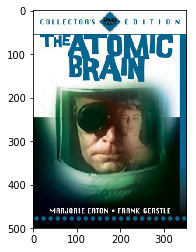

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

Read all images

In [8]:
images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

100%|████████████████████████████████████████████████████| 7895/7895 [00:10<00:00, 740.79it/s]


In [9]:
images_training = np.stack(images_training)
images_training.shape, dataTraining.shape[0]

((7895, 40960), 7895)

In [10]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

100%|████████████████████████████████████████████████████| 3383/3383 [00:04<00:00, 823.41it/s]


In [11]:
images_testing = np.stack(images_testing)
images_testing.shape, dataTesting.shape[0]

((3383, 40960), 3383)

## Apply PCA

In [12]:
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
import time
time0 = time.time()
pca = PCA(n_components = 32)
images_training_pca = pca.fit_transform(images_training)
time1 = time.time()
print(time1-time0)

19.107325315475464


In [13]:
images_testing_pca = pca.transform(images_testing)

# Create y

In [14]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [15]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training_pca, y_genres, test_size=0.20, random_state=666)

# Train multi-class multi-label model

In [21]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

In [28]:
ovr = OneVsRestClassifier(LogisticRegression())
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=24, random_state=666))
neigh = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=20))

In [29]:
ovr_mod = ovr.fit(X_train,y_train_genres)
clf_mod = clf.fit(X_train, y_train_genres)
neigh_mod = neigh.fit(X_train, y_train_genres)

# Predict Logistic Regression

In [30]:
y_pred_genres_ovr = ovr_mod.predict_proba(X_test)

In [32]:
roc_auc_score(y_test_genres, y_pred_genres_ovr, average='micro')

0.8094865573057869

In [39]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = ovr.predict_proba(images_testing_pca)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_LR.csv', index_label='ID')

# Predict Random Forest

In [33]:
y_pred_genres_clf = clf_mod.predict_proba(X_test)

In [35]:
roc_auc_score(y_test_genres, y_pred_genres_clf, average='micro')

0.7907181168814663

In [40]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(images_testing_pca)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')

# Predict K Neighbors

In [36]:
y_pred_genres_neigh = neigh_mod.predict_proba(X_test)

In [37]:
roc_auc_score(y_test_genres, y_pred_genres_neigh, average='micro')

0.7792532300971542

In [41]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = neigh.predict_proba(images_testing_pca)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_KN.csv', index_label='ID')